## Identification of Spatially Variable Genes (SVGs)

SVGs are typically identified using q-value and FSV thresholds.
However, during our analysis we observed that relying on these two metrics alone often led to the selection of false-positive SVGs.
For this reason, we decided to explore additional variables that may be more reliable indicators of true spatial variation. 

This notebook provides a unified workflow for visually and quantitatively evaluating SVG candidates detected by SpatialDE or SOMDE.

What the notebook does: 
- Loads and standardizes results from SpatialDE or SOMDE
- Generates a simple volcano plot of all SVG candidates
- Allows interactive inspection of spatial expression maps
- Lets the user manually label genes as TRUE or FALSE SVGs (based on spatial maps from the previous step)
- Plots key variables (fraction_expressing, FSV, LLR, q-value, etc.) to compare how TRUE and FALSE SVGs differ
- Helps identify which statistical variables are useful for filtering out false SVGs

How to use it: 
- Set the correct paths to the files from the previous analysis.
- Inspect spatial expression maps and decide which genes appear true vs false SVGs.
- Edit the lists of TRUE and FALSE SVGs accordingly.
- Use the summary plots to see which metrics best separate meaningful spatial patterns from noise.

This notebook is intended as a visual QC tool, not an automated classifier.
Its purpose is to help you understand which variables reliably distinguish true spatial signals.

Import necessary libraries:

In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import ipywidgets as w
w.IntSlider()

IntSlider(value=0)

### Visualisation and Identification of SVGs 

In [ ]:
# detailed per-gene statistics produced by the SVG detection method
res_p = r"data_after_qc\SN048_A121573_Rep1\results_spatialDE\res.csv"
# main output file with key metrics for each gene (e.g., FSV, q-value, test statistics)
results_p = r"data_after_qc\SN048_A121573_Rep1\results_spatialDE\results.csv"
# coordinates of spatial spots used for visualizing expression patterns
sample_info_p = r"data_after_qc\SN048_A121573_Rep1\results_spatialDE\sample_info.csv"
# raw (unnormalized) count matrix of genes × spots, used to compute fraction_expressing
expr_counts_path = r"data_after_qc\SN048_A121573_Rep1\count.not_normalized.csv"

res = pd.read_csv(res_p, index_col=0)
results = pd.read_csv(results_p, index_col=0)
sample_info = pd.read_csv(sample_info_p, index_col=0)

# Base folder to save all output
base_dir = r"data_after_qc\SN048_A121573_Rep1\results_spatialDE"

Volkano plot - the relation between significance and effect size. Efect size is the fraction of variance explained by spatial variation.

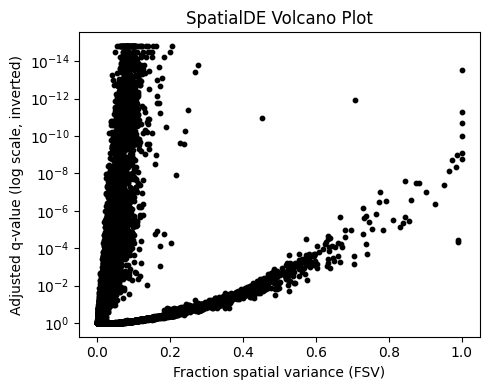

In [ ]:
# Filter out non-positive q-values (cannot be shown on log scale)
plot_data = results[results['qval'] > 0].copy()

plt.figure(figsize=(5, 4))
plt.scatter(plot_data['FSV'], plot_data['qval'], c='black', s=10)

plt.yscale('log')          # log-scale on y-axis
plt.gca().invert_yaxis()   # more significant (smaller q) at the top

plt.xlabel('Fraction spatial variance (FSV)')
plt.ylabel('Adjusted q-value (log scale, inverted)')
plt.title('Volcano Plot')

plt.tight_layout()

# Optional: save to file
volcano_file = os.path.join(base_dir, "volcano_simple.png")
plt.savefig(volcano_file, dpi=300)

plt.show()

Then there are choosen the best genes.

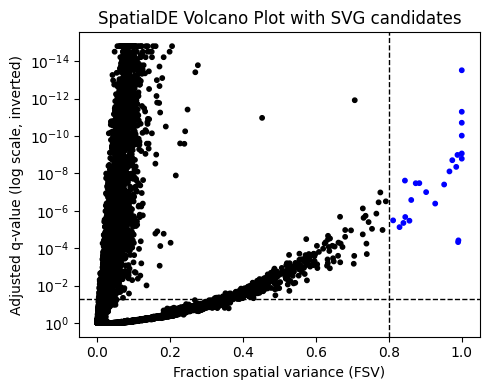

In [ ]:

# Thresholds for SVG candidates
fsv_thr = 0.8
q_thr = 0.05

# Filter out non-positive q-values
plot_data = results[results['qval'] > 0].copy()

# Define colors based on thresholds
colors = [
    'blue' if (row['FSV'] >= fsv_thr and row['qval'] <= q_thr) else 'black'
    for _, row in plot_data.iterrows()
]

plt.figure(figsize=(5, 4))
plt.scatter(plot_data['FSV'], plot_data['qval'], c=colors, s=10)

plt.yscale('log')
plt.gca().invert_yaxis()

# Threshold lines (in data space – works fine with log+invert)
plt.axhline(q_thr, color='black', lw=1, ls='--')
plt.axvline(fsv_thr, color='black', lw=1, ls='--')

plt.xlabel('Fraction spatial variance (FSV)')
plt.ylabel('Adjusted q-value (log scale, inverted)')
plt.title('Volcano Plot with SVG candidates')

plt.tight_layout()

volcano_file_svg = os.path.join(base_dir, "volcano_svg_candidates.png")
plt.savefig(volcano_file_svg, dpi=300)

plt.show()

In [ ]:
from IPython.display import display

# ============================================================
# 1) SELECT STRICT SVG GENES (TOP ~20 FROM VOLCANO)
# ============================================================

# Thresholds used to define "strict" SVGs
fsv_thr = 0.8
q_thr = 0.05

# Boolean mask for top-right volcano area
mask_top_right = (results['FSV'] >= fsv_thr) & (results['qval'] <= q_thr)

# Select genes, sort by q-value, keep TOP 20 most significant
strict_gene_list = (
    results.loc[mask_top_right, ['g', 'qval']]
           .dropna()
           .sort_values('qval')
           .drop_duplicates(subset='g')
           .head(20)['g']
           .tolist()
)

print(f"Number of strict SVG candidates: {len(strict_gene_list)}")
print(strict_gene_list)

# Map gene → q-value for plotting
qval_map = results.set_index('g')['qval'].to_dict()


# ============================================================
# 2) FUNCTION TO PLOT SPATIAL EXPRESSION OF A GENE
# ============================================================

def plot_gene(gene):
    """Plot spatial expression map for a single gene."""

    if gene not in res.columns:
        print(f"Gene {gene} not found in expression matrix `res`.")
        return

    qval = qval_map.get(gene, None)
    if qval is not None:
        title = f"{gene} (q = {qval:.2e})"
    else:
        title = gene

    fig, ax = plt.subplots(figsize=(5, 5))

    sc = ax.scatter(
        sample_info['x'],
        sample_info['y'],
        c=res[gene],
        cmap='viridis',
        s=12,
        edgecolors='none'
    )

    ax.set_title(title, fontsize=12)
    ax.set_aspect('equal')

    ax.set_xticks([])
    ax.set_yticks([])

    cbar = fig.colorbar(sc, ax=ax, fraction=0.035, pad=0.01)
    cbar.set_label('Expression', fontsize=10)
    cbar.ax.tick_params(labelsize=9)

    fig.tight_layout()

    # Save PNG
    file_path = os.path.join(base_dir, f"{gene}.png")
    fig.savefig(file_path, dpi=300, bbox_inches='tight')

    plt.show()
    plt.close(fig)


# ============================================================
# 3) DROPDOWN TO SELECT AND PLOT ONE GENE AT A TIME
# ============================================================

dropdown = w.Dropdown(
    options=strict_gene_list,
    description="SVG:",
    style={'description_width': '60px'},
    layout=w.Layout(width='250px')
)

w.interact(plot_gene, gene=dropdown)

Number of strict SVG candidates: 20
['FCGBP', 'RPS24', 'PIGR', 'MUC2', 'PPY', 'LY86-AS1', 'AC004593.2', 'C10orf55', 'LKAAEAR1', 'AC009065.3', 'MIR4500HG', 'AC018529.2', 'PCDHGA2', 'HBG2', 'AC140912.1', 'KRT6A', 'C22orf24', 'COL25A1', 'AL137786.1', 'DKK2']


interactive(children=(Dropdown(description='SVG:', layout=Layout(width='250px'), options=('FCGBP', 'RPS24', 'P…

<function __main__.plot_gene(gene)>


Manual SVG inspection

In the previous step you have looked at spatial expression maps for these genes.
Now you can use the barplots below to visually (by eye) distinguish:

  • likely TRUE SVGs – genes with:
      - high fraction_expressing (expressed in a reasonable fraction of spots)
      - high FSV (large fraction of spatial variance)
      - high LLR and very low q-value
      - stable, non-extreme parameter estimates (e.g. max_delta, max_mu_hat)
  • likely FALSE SVGs – genes that were called significant by the method,
    but probably represent noise or technical artifacts:
      - very low fraction_expressing (signal driven by a few spots)
      - modest FSV with noisy/patchy spatial pattern
      - borderline LLR / q-values
      - unstable or extreme parameter estimates in model selection

This code cell is intended to help you identify which output variables
(FSV, fraction_expressing, LLR, qval, and model-selection parameters)
are most useful to filter out likely FALSE SVGs

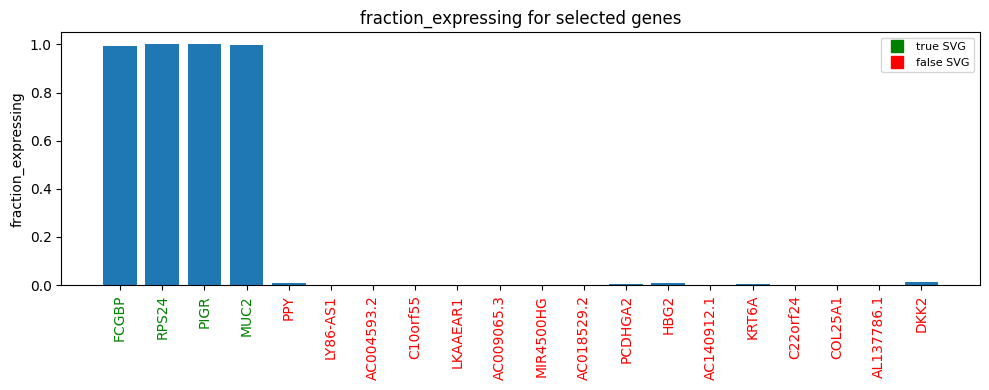

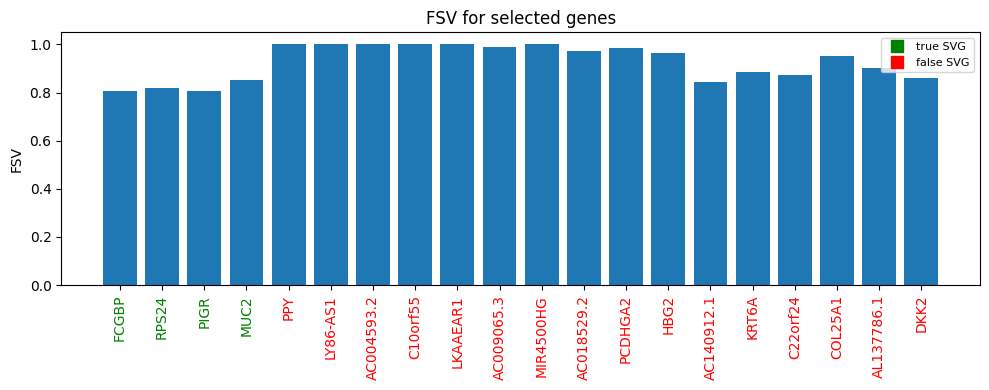

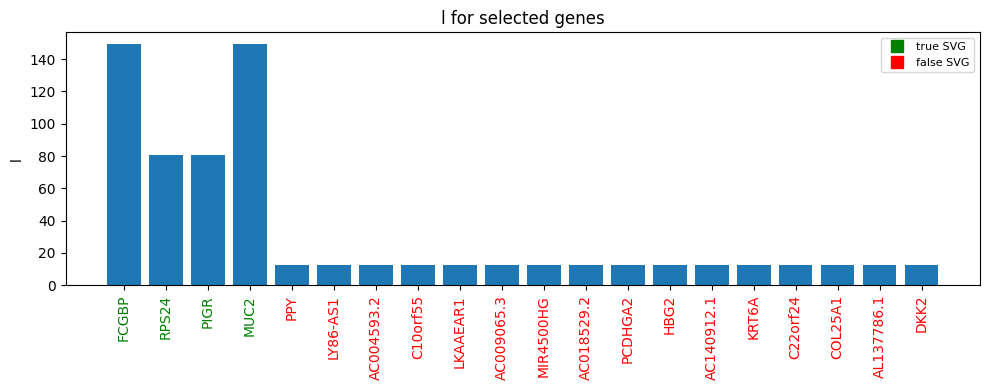

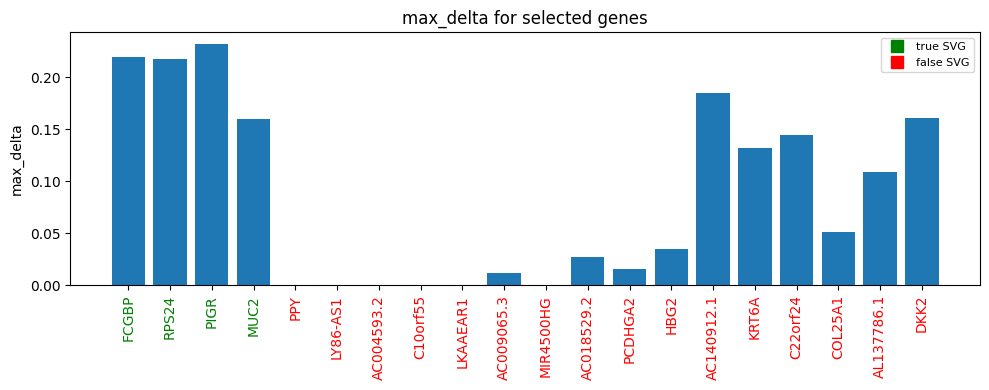

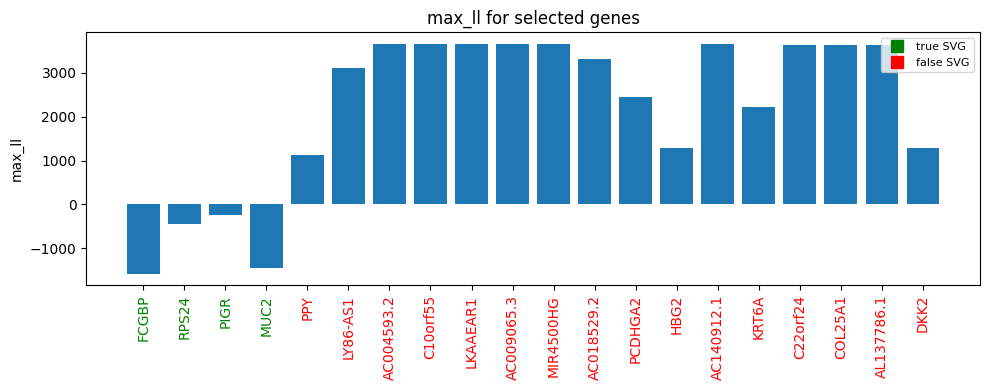

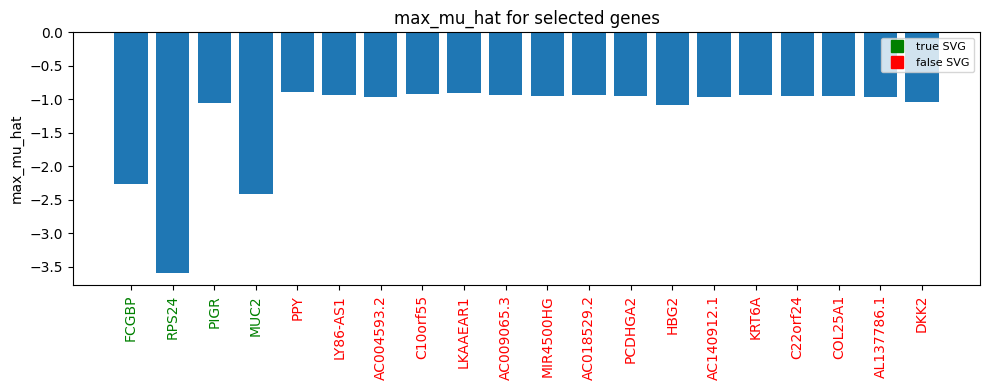

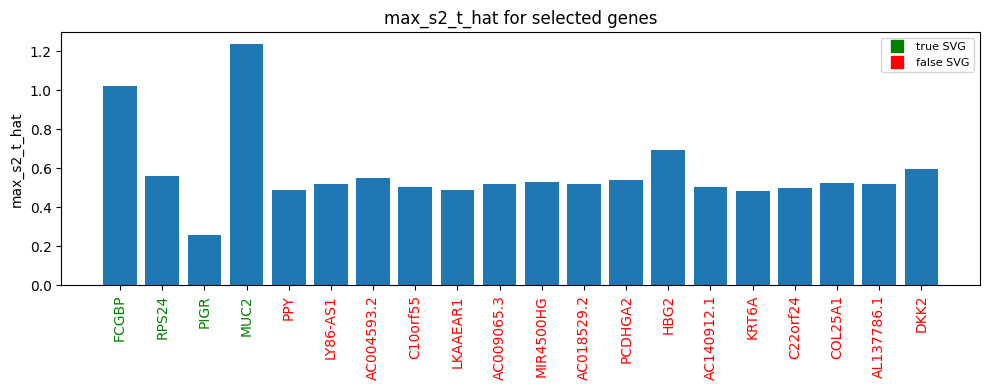

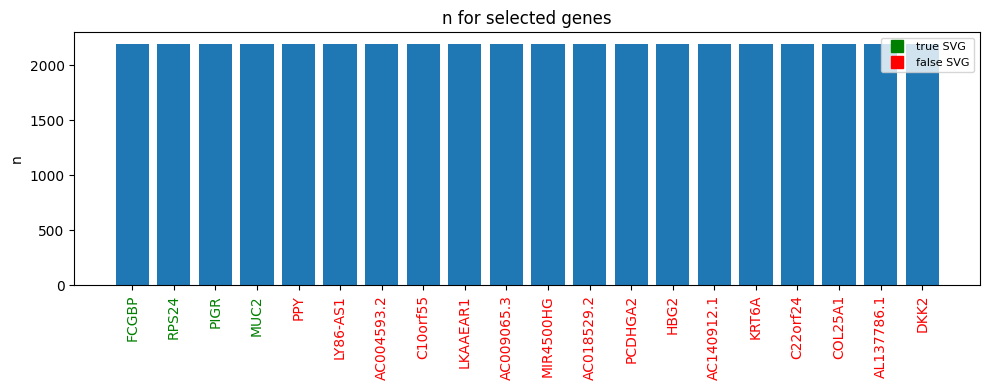

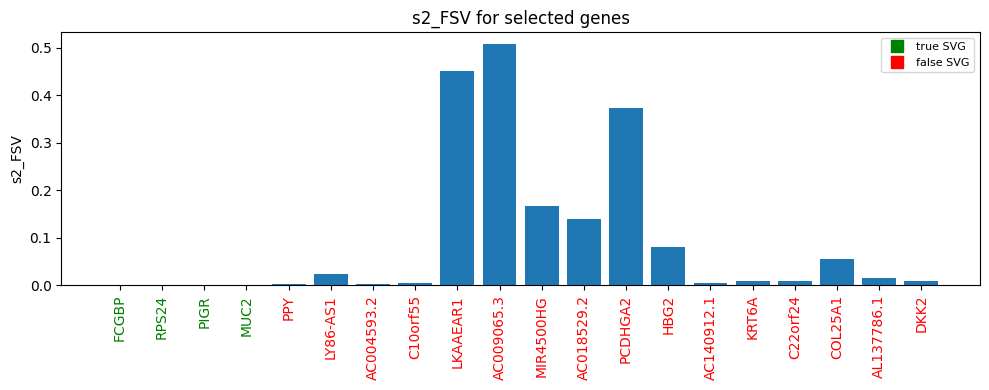

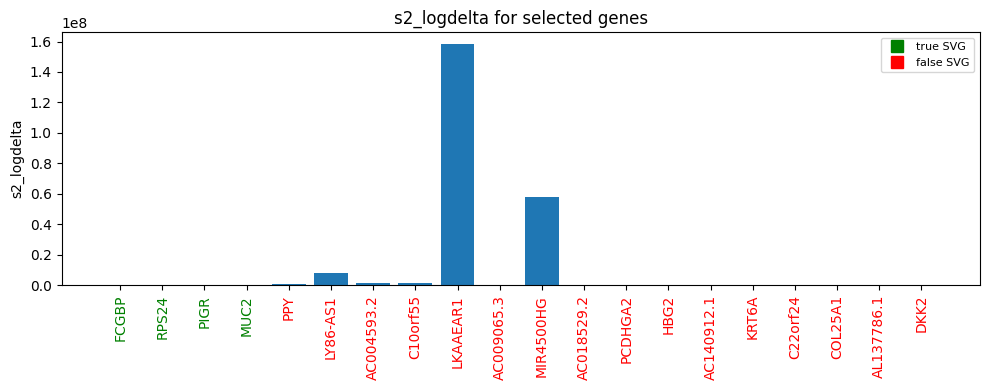

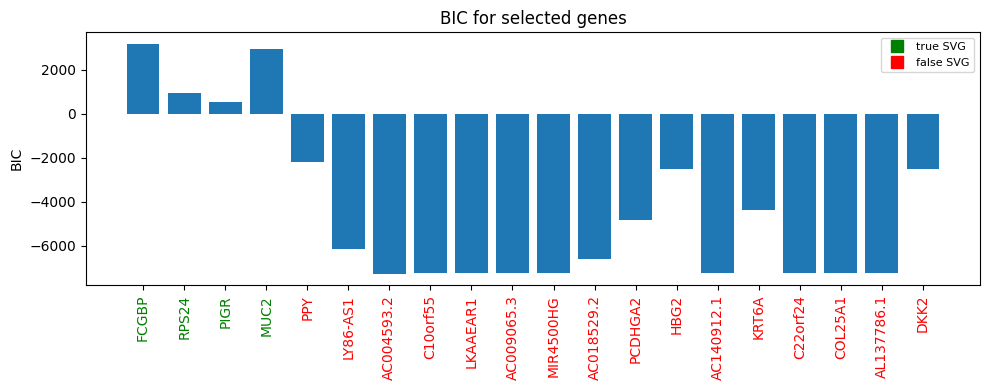

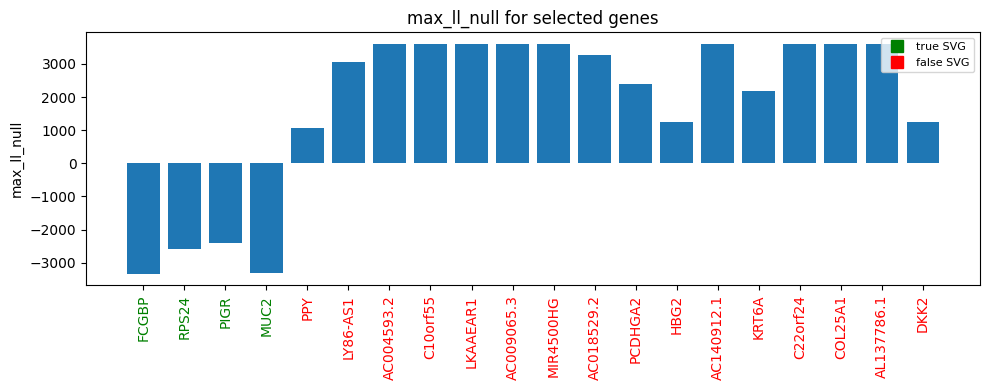

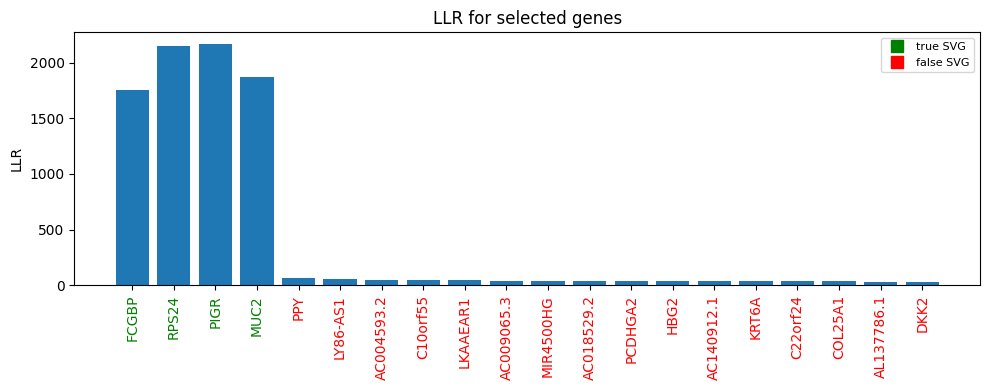

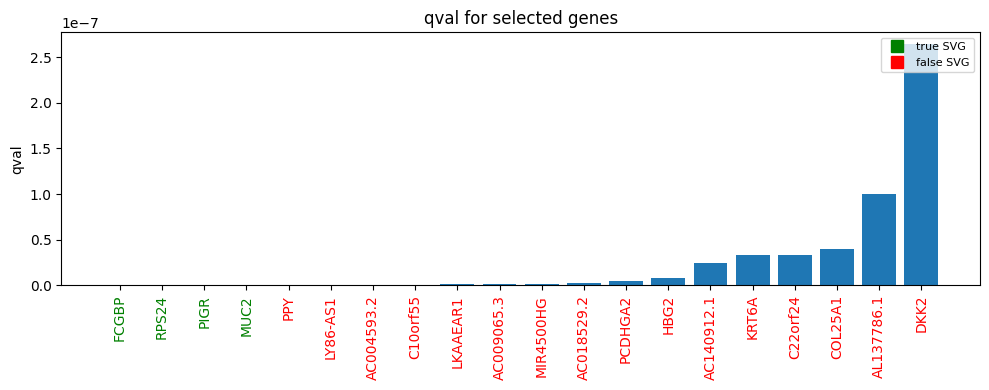

In [ ]:
# ============================================================
# 0) SHORT INSTRUCTION FOR THE USER
# ============================================================
instruction_text = """
Manual SVG inspection

In the previous step you have looked at spatial expression maps for these genes.
Now you can use the barplots below to visually (by eye) distinguish:

  • likely TRUE SVGs – genes with:
      - high fraction_expressing (expressed in a reasonable fraction of spots)
      - high FSV (large fraction of spatial variance)
      - high LLR and very low q-value
      - stable, non-extreme parameter estimates (e.g. max_delta, max_mu_hat)
  • likely FALSE SVGs – genes that were called significant by the method,
    but probably represent noise or technical artifacts:
      - very low fraction_expressing (signal driven by a few spots)
      - modest FSV with noisy/patchy spatial pattern
      - borderline LLR / q-values
      - unstable or extreme parameter estimates in model selection

This code cell is intended to help you identify which output variables
(FSV, fraction_expressing, LLR, qval, and model-selection parameters)
are most useful to filter out likely FALSE SVGs while keeping TRUE SVGs.

In the plots below:
  • TRUE SVGs are marked in GREEN
  • FALSE SVGs are marked in RED

Use these summaries together with the spatial maps from the previous cell.
The classification into TRUE and FALSE SVGs should always be based on the
spatial expression maps you inspected visually before running this cell.
"""
print(instruction_text)

# ============================================================
# 1) DEFINE GENE SETS
# ============================================================

# Manually curated TRUE SVGs (based on spatial maps from previous cell)
true_svg_genes = [
    'FCGBP',
    'RPS24',
    'PIGR',
    'MUC2'
]

# All genes of interest (TRUE + FALSE SVG candidates)
genes_of_interest = [
    'FCGBP', 
    'RPS24', 
    'PIGR', 
    'MUC2', 
    'PPY', 
    'LY86-AS1', 
    'AC004593.2', 
    'C10orf55', 
    'LKAAEAR1', 
    'AC009065.3', 
    'MIR4500HG', 
    'AC018529.2', 
    'PCDHGA2', 
    'HBG2', 
    'AC140912.1', 
    'KRT6A', 
    'C22orf24', 
    'COL25A1', 
    'AL137786.1', 
    'DKK2'
]

# All other genes in this list are treated as FALSE SVGs
false_svg_genes = [g for g in genes_of_interest if g not in true_svg_genes]

# ============================================================
# 2) ENSURE fraction_expressing IS AVAILABLE IN `results`
# ============================================================

if "fraction_expressing" not in results.columns:
    # Raw (non-normalized) count matrix
    counts = pd.read_csv(expr_counts_path, index_col=0)  # rows = spots, cols = genes

    # Keep only genes which are present both in `results` and in the count matrix
    common_genes = [g for g in results["g"] if g in counts.columns]
    counts = counts[common_genes]

    # Fraction of spots with expression > 0
    fraction_expressing = (counts > 0).sum(axis=0) / counts.shape[0]

    # Align to results['g'] order
    frac_series = fraction_expressing.reindex(results["g"])
    results["fraction_expressing"] = frac_series.values

# ============================================================
# 3) SUBSET `results` TO GENES OF INTEREST AND ORDER THEM
# ============================================================

sub = results[results["g"].isin(genes_of_interest)].copy()

# Preserve the order defined in genes_of_interest
sub["gene_order"] = sub["g"].map({g: i for i, g in enumerate(genes_of_interest)})
sub = sub.sort_values("gene_order")

# Add label TRUE/FALSE SVG
sub["svg_label"] = np.where(sub["g"].isin(true_svg_genes), "true", "false")

# X-axis positions and labels
x_pos = np.arange(len(sub))
gene_labels = sub["g"].tolist()

# ============================================================
# 4) VARIABLES TO PLOT (INCLUDING fraction_expressing)
# ============================================================

vars_to_plot = [
    "fraction_expressing",  # added
    "FSV",
    "l",
    "max_delta",
    "max_ll",
    "max_mu_hat",
    "max_s2_t_hat",
    "n",
    "s2_FSV",
    "s2_logdelta",
    "BIC",
    "max_ll_null",
    "LLR",
    "qval"
]

# Output folder 
base_dir = os.path.dirname(results_p)
os.makedirs(base_dir, exist_ok=True)

# Color mapping for gene labels
label_colors = {
    "true": "green",
    "false": "red"
}

# ============================================================
# 5) LOOP OVER VARIABLES AND DRAW BARPLOTS
#    with GREEN labels for true SVGs and RED for false SVGs
# ============================================================

for var in vars_to_plot:
    if var not in sub.columns:
        print(f"Variable '{var}' not found in results columns – skipped.")
        continue

    values = sub[var].values

    plt.figure(figsize=(10, 4))
    plt.bar(x_pos, values)

    plt.xticks(x_pos, gene_labels, rotation=90)
    plt.ylabel(var)
    plt.title(f"{var} for selected genes")

    # Color x-axis tick labels according to TRUE/FALSE SVG status
    ax = plt.gca()
    for tick, gene in zip(ax.get_xticklabels(), gene_labels):
        if gene in true_svg_genes:
            tick.set_color("green")
        else:
            tick.set_color("red")

    # Legend for true / false SVG
    true_patch = plt.Line2D([0], [0], color="green", marker="s", linestyle="None",
                            markersize=8, label="true SVG")
    false_patch = plt.Line2D([0], [0], color="red", marker="s", linestyle="None",
                             markersize=8, label="false SVG")
    ax.legend(handles=[true_patch, false_patch], loc="upper right", fontsize=8)

    plt.tight_layout()

    # Save figure
    out_path = os.path.join(base_dir, f"genes_of_interest_{var}.png")
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.show()